In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# /content/
! rm -rf /content/cats
! rm -rf /content/celebs
! cp /content/drive/MyDrive/cs389/cats.zip /content/
! cp /content/drive/MyDrive/cs389/celebs.zip /content/
! rm -rf /content/cats
! rm -rf /content/celebs
! unzip /content/cats.zip -d /content/
! unzip /content/celebs.zip -d /content/
! rm /content/celebs/.DS_Store
! rm /content/cats/.DS_Store
! rm -rf /content/__MACOSX/
! rm -rf /content/__MACOSX/

In [ ]:
import torchvision.transforms as transforms
from torchvision import datasets, transforms
import torchvision
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import itertools
import numpy as np
import tqdm
import os
import glob
import random
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


In [ ]:
class ImageDataset(Dataset):
    def __init__(self):
        self.transform = transforms.Compose([transforms.Resize((128, 128), Image.BICUBIC),
                transforms.ToTensor()])

        self.files_A = sorted(glob.glob('/content/celebs/celebs_dataset/*.jpg'))
        self.files_B = sorted(glob.glob('/content/cats/cats_dataset/*.jpg'))
        self.unaligned = True

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

2000 2000
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])


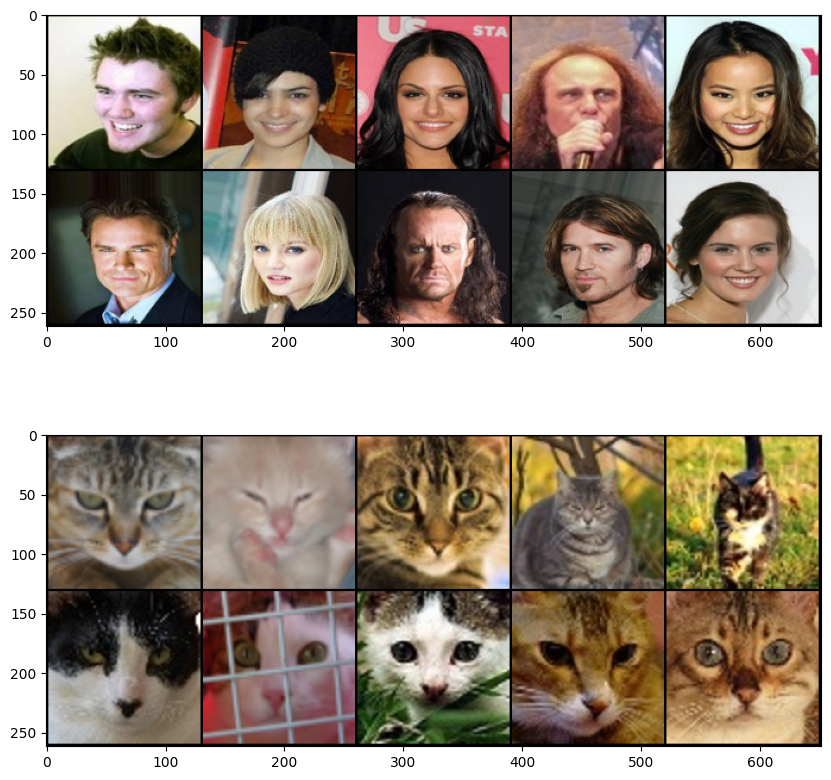

In [ ]:
image_dataset = ImageDataset()
A_size = (3, 129, 128)
B_size = (3, 128, 128)

example_loader = DataLoader(image_dataset, batch_size=10)

print(len(image_dataset.files_A), len(image_dataset.files_B))

for i, batch in enumerate(example_loader):
  if i > 0:
    break

  A = batch['A']
  B = batch['B']

  print(A[0].size())
  print(B[0].size())

  grid_img_A = torchvision.utils.make_grid(A, nrow=5)
  grid_img_B = torchvision.utils.make_grid(B, nrow=5)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(2, 1, 1)
  plt.imshow(grid_img_A.permute(1, 2, 0))
  plt.subplot(2, 1, 2)
  plt.imshow(grid_img_B.permute(1, 2, 0))

  plt.show()

In [ ]:
class Generator(nn.Module):
  def __init__(self): # 3, 128, 128
    super(Generator, self).__init__()

    # o = (i + 2p - k) / s + 1

    # encoder layer
    model = [
        # Layer 1, (3, 128, 128)
        nn.Conv2d(3, 64, 8, padding=4),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        # Layer 2, (64, 127, 127)
        nn.Conv2d(64, 128, 3, stride=2, padding=2, padding_mode="reflect"),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        # Layer 3, (128, 65, 65)
        nn.Conv2d(128, 256, 3, stride=2, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
    ]

    # residuals
    model += [
        # Layer 4, (256, 33, 33)
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.Identity(),

        # Layer 5, (256, 33, 33)
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.Identity(),

        # Layer 6, (256, 33, 33)
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.Identity(),

        # Layer 7, (256, 33, 33)
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.Identity(),

        # Layer (8), (256, 33, 33)
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.ReLU(inplace=True),
        nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        nn.InstanceNorm2d(256),
        nn.Identity(),

        # Layer (9), (256, 33, 33)
        # nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        # nn.InstanceNorm2d(256),
        # nn.ReLU(inplace=True),
        # nn.Conv2d(256, 256, 3, padding=1, padding_mode="reflect"),
        # nn.InstanceNorm2d(256),
        # nn.Identity(),
    ]

    # decoder
    model += [
        # Layer 8, (256, 33, 33)
        nn.ConvTranspose2d(256, 128, 3, padding=1, stride=2),
        nn.InstanceNorm2d(128),
        nn.ReLU(inplace=True),

        # Layer 9, (128, 65, 65)
        nn.ConvTranspose2d(128, 64, 3, padding=2, stride=2),
        nn.InstanceNorm2d(64),
        nn.ReLU(inplace=True),

        # Layer 10, (64, 127, 127)
        nn.ConvTranspose2d(64, 3, 8, padding=3),
        nn.Sigmoid()
    ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    x = self.model(x)
    # x = torch.tanh(x)

    return x

In [ ]:
example_generator = Generator().to(device)

for i, batch in enumerate(example_loader):
  if i > 0:
    break

  A = batch['A'].to(device)
  B = batch['B'].to(device)

  fake_B = example_generator(A)
  fake_A = example_generator(B)

  print(fake_B.shape)
  print(fake_A.shape)


torch.Size([10, 3, 128, 128])
torch.Size([10, 3, 128, 128])


In [ ]:
class Discriminator(nn.Module):
  def __init__(self): # (3, 128, 128)
    super().__init__()

    model = [
        # Layer 1, (3, 128, 128)
        nn.Conv2d(3, 64, 4, stride=2, padding=1, padding_mode="reflect", bias=True),
        nn.InstanceNorm2d(64),
        nn.LeakyReLU(0.2, inplace=True),

        # Layer 2, (64, 64, 64)
        nn.Conv2d(64, 128, 4, stride=2, padding=1, padding_mode="reflect", bias=True),
        nn.InstanceNorm2d(128),
        nn.LeakyReLU(0.2, inplace=True),

        # Layer 3, (128, 32, 32)
        nn.Conv2d(128, 256, 4, stride=2, padding=1, padding_mode="reflect", bias=True),
        nn.InstanceNorm2d(256),
        nn.LeakyReLU(0.2, inplace=True),

        # Layer 4, (256, 16, 16)
        nn.Conv2d(256, 512, 4, stride=2, padding=1, padding_mode="reflect", bias=True),
        nn.InstanceNorm2d(512),
        nn.LeakyReLU(0.2, inplace=True),

        # Layer 5, (512, 8, 8)
        nn.Conv2d(512, 1, 4, stride=1, padding=2, padding_mode="reflect", bias=True),
    ]

    self.model = nn.Sequential(*model)

  def forward(self, x):
    x = self.model(x)
    x = torch.sigmoid(x)

    return x

In [ ]:
example_discriminator = Discriminator().to(device)

for i, batch in enumerate(example_loader):
  if i > 0:
    break

  A = batch['A'].to(device)
  B = batch['B'].to(device)

  fake_B = example_discriminator(A)
  fake_A = example_discriminator(B)

  print(fake_B.shape)
  print(fake_A.shape)

torch.Size([10, 1, 9, 9])
torch.Size([10, 1, 9, 9])


In [ ]:
BATCH_SIZE = 4
LEARNING_RATE = 1e-4
LAMBDA_CYCLE = 10
NUM_EPOCHS = 100

ROOT_PATH = "/content/drive/MyDrive/cs389/models/may6-3"
GENA2B_PATH = ROOT_PATH + "/gena2b.pth"
GENB2A_PATH = ROOT_PATH + "/genb2a.pth"
DISA_PATH = ROOT_PATH + "/disa.pth"
DISB_PATH = ROOT_PATH + "/disb.pth"

def save_checkpoint(model, optimizer, filename="models/checkpoint.pth"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

def seed_everything(seed=42):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def show_batch(real_batch, fake_batch, recon_batch):
  grid_img_real = torchvision.utils.make_grid(real_batch, nrow=5)
  grid_img_fake = torchvision.utils.make_grid(fake_batch, nrow=5)
  grid_img_recon = torchvision.utils.make_grid(recon_batch, nrow=5)

  fig = plt.figure(figsize=(10, 10))
  plt.subplot(3, 1, 1)
  plt.imshow(grid_img_real.permute(1, 2, 0))
  plt.subplot(3, 1, 2)
  plt.imshow(grid_img_fake.permute(1, 2, 0))
  plt.subplot(3, 1, 3)
  plt.imshow(grid_img_recon.permute(1, 2, 0))
  plt.show()

In [ ]:
saved_batches = []
def train(disc_A: Discriminator, disc_B: Discriminator, gen_a2b: Generator, gen_b2a: Generator, loader, opt_disc, opt_gen, l1, mse):
  loop = tqdm(loader, leave=True)
  D_loss_list = []
  G_loss_list = []

  # r = [random.randint(0, 200) for _ in range(3)]
  r = random.randint(0, 490)

  for idx, batch in enumerate(loop):
    real_A = batch['A'].to(device)
    real_B = batch['B'].to(device)

    # train discriminators A and B
    fake_A = gen_b2a(real_B)
    D_A_real = disc_A(real_A)
    D_A_fake = disc_A(fake_A.detach())
    D_A_real_loss = mse(D_A_real, torch.ones_like(D_A_real)) # pred for real should be same shape 1
    D_A_fake_loss = mse(D_A_fake, torch.zeros_like(D_A_fake)) # pred for fake should be same shape 0
    D_A_loss = D_A_real_loss + D_A_fake_loss

    fake_B = gen_a2b(real_A)
    D_B_real = disc_B(real_B)
    D_B_fake = disc_B(fake_B.detach())
    D_B_real_loss = mse(D_B_real, torch.ones_like(D_B_real))
    D_B_fake_loss = mse(D_B_fake, torch.zeros_like(D_B_fake))
    D_B_loss = D_B_real_loss + D_B_fake_loss

    D_loss = (D_A_loss + D_B_loss) / 2

    opt_disc.zero_grad()
    D_loss.backward()
    opt_disc.step()

    # train generators A2B and B2A
    D_A_fake = disc_A(fake_A)
    D_B_fake = disc_B(fake_B)

    loss_G_B2A = mse(D_A_fake, torch.ones_like(D_A_fake))
    loss_G_A2B = mse(D_B_fake, torch.ones_like(D_B_fake))

    cycle_A = gen_b2a(fake_B)
    cycle_B = gen_a2b(fake_A)
    cycle_A_loss = l1(cycle_A, real_A)
    cycle_B_loss = l1(cycle_B, real_B)

    G_loss = (loss_G_B2A + loss_G_A2B + cycle_A_loss * LAMBDA_CYCLE + cycle_B_loss * LAMBDA_CYCLE)

    opt_gen.zero_grad()
    G_loss.backward()
    opt_gen.step()

    G_loss_list.append(G_loss.detach().cpu())
    D_loss_list.append(D_loss.detach().cpu())

    if idx == r:
      saved_batches.append((real_A.detach().cpu(), fake_B.detach().cpu(), cycle_A.detach().cpu()))

    # if idx == r:
    #   show_batch(real_batch=real_A.detach().cpu(), fake_batch=fake_B.detach().cpu(), recon_batch=cycle_A.detach().cpu())

  return D_loss_list, G_loss_list

$L_{G_{B2A}} = (A_{fake} -1)^2$

$L_{G_{A2B}} = (B_{fake} - 1)^2$

$L_{cycle_A} = |A_{recon} - A|$

$L_{cycle_B} = |B_{recon} - B|$

$\lambda_{cycle} = 10$

$L_{G} = L_{G_{B2A}} + L_{G_{A2B}} + L_{cycle_A} * \lambda_{cycle} + L_{cycle_B} * \lambda_{cycle}$

---
$L_{D_{A}} = (A_{real} - 1)^2 + (A_{fake} - 0)^2$

$L_{D_{B}} = (B_{real} - 1)^2 + (B_{fake} - 0)^2$

$L_{D} = \frac{L_{D_{B}} + L_{D_{A}}}{2}$

In [ ]:
disc_A = Discriminator().to(device)
disc_B = Discriminator().to(device)
gen_A2B = Generator().to(device)
gen_B2A = Generator().to(device)

opt_disc = torch.optim.Adam(list(disc_A.parameters()) + list(disc_B.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)
opt_gen = torch.optim.Adam(list(gen_A2B.parameters()) + list(gen_B2A.parameters()), lr=LEARNING_RATE, betas=(0.5, 0.999),)

# scheduler = torch.optim.lr_scheduler.StepLR(opt_gen, step_size=25, gamma=0.1)

L1 = nn.L1Loss()
mse = nn.MSELoss()

loader = DataLoader(image_dataset, batch_size=BATCH_SIZE)

100%|██████████| 500/500 [00:39<00:00, 12.61it/s]


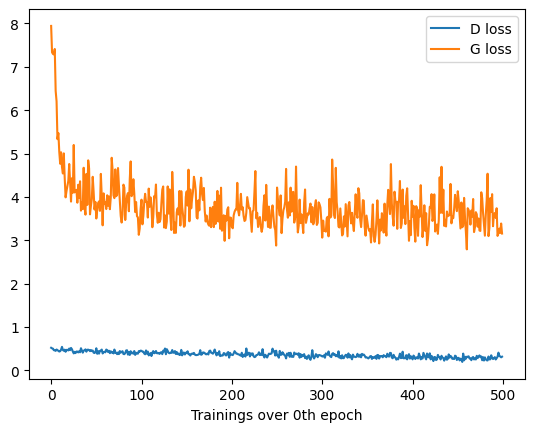

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:38<00:00, 12.91it/s]


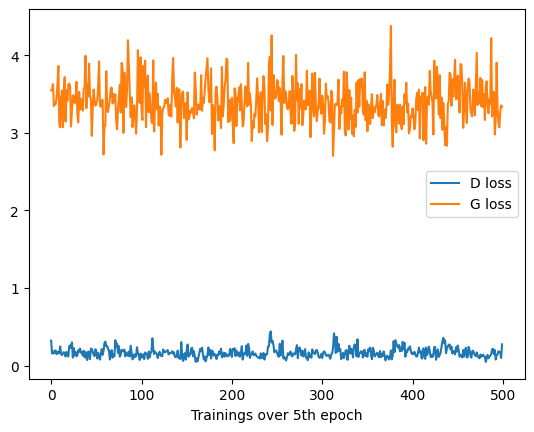

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:38<00:00, 12.83it/s]


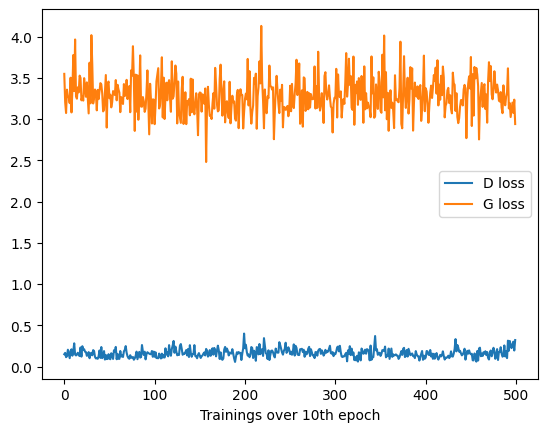

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.70it/s]


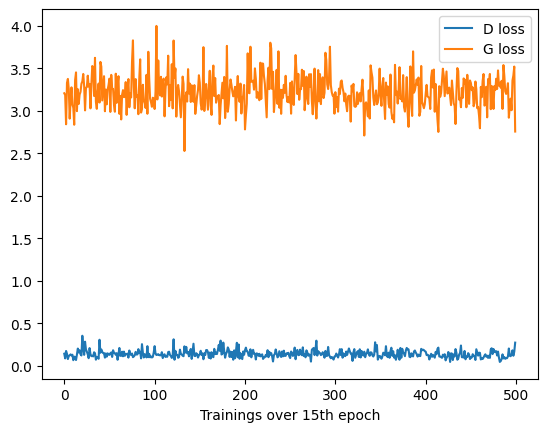

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.64it/s]


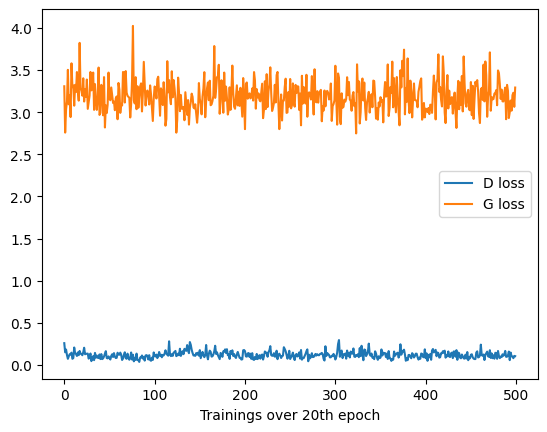

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.58it/s]


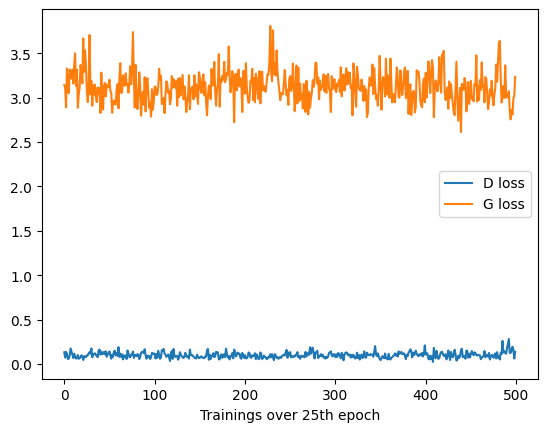

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.51it/s]


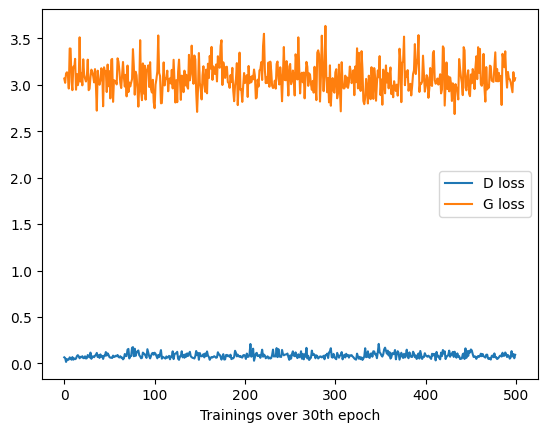

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.54it/s]


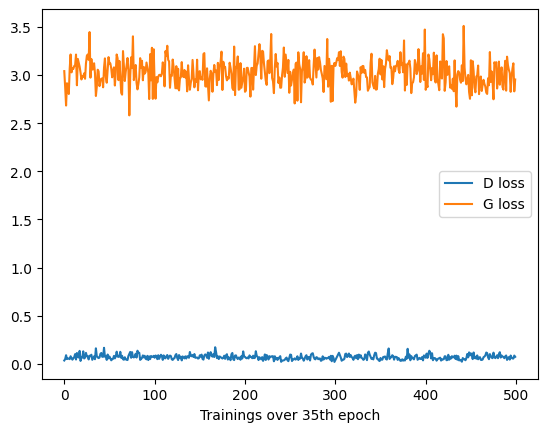

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.58it/s]


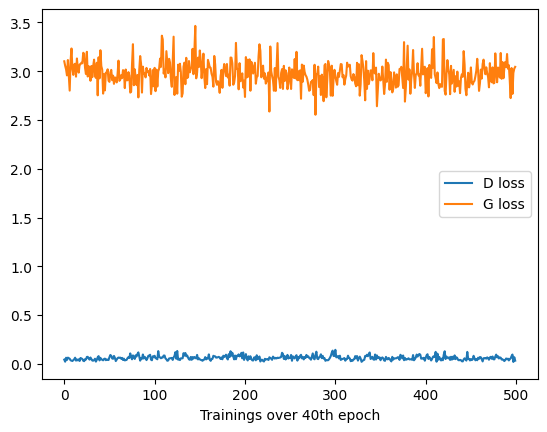

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.65it/s]


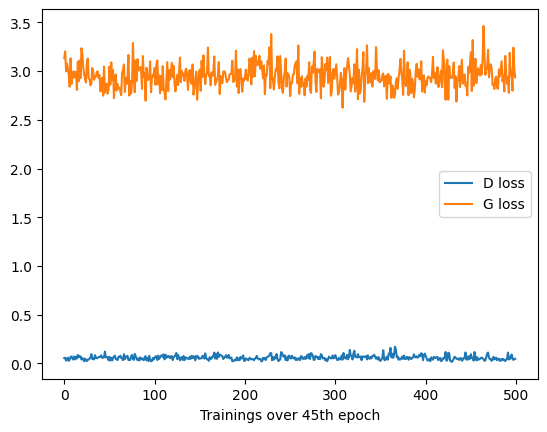

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.50it/s]


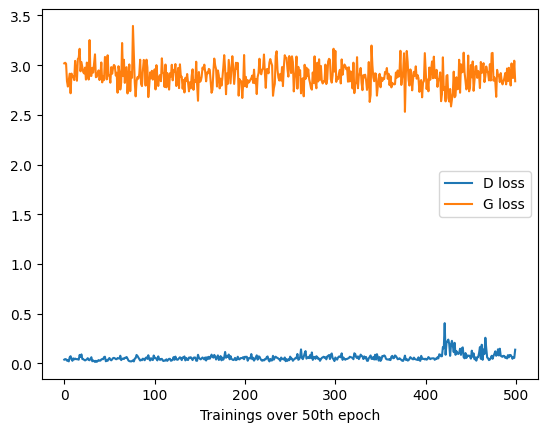

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.36it/s]


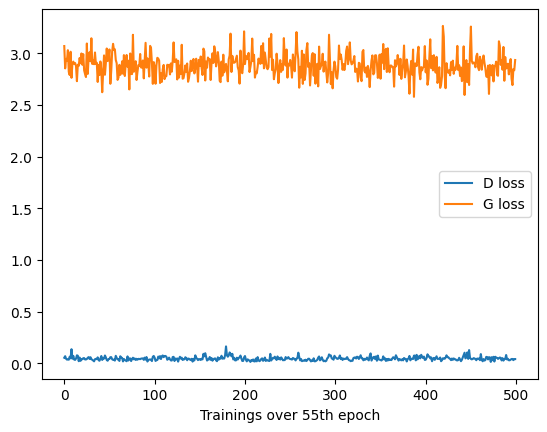

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:39<00:00, 12.50it/s]


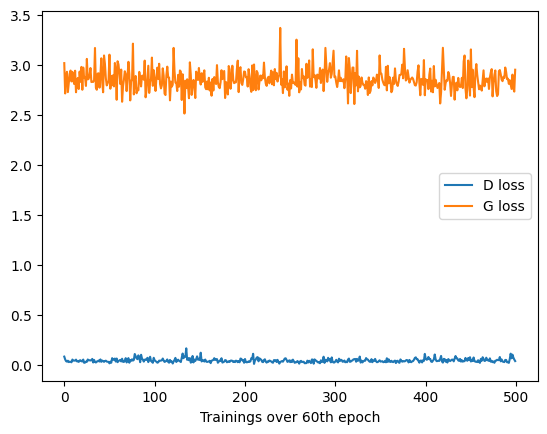

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.43it/s]


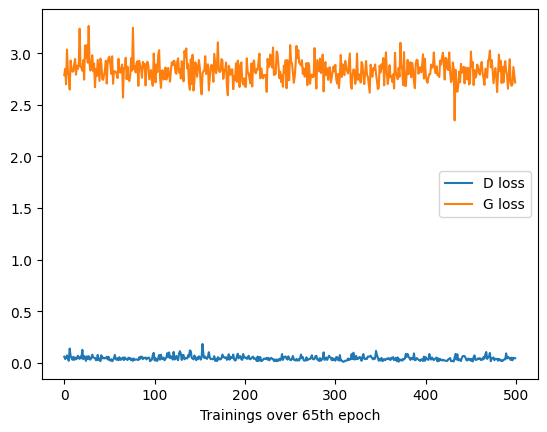

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.46it/s]


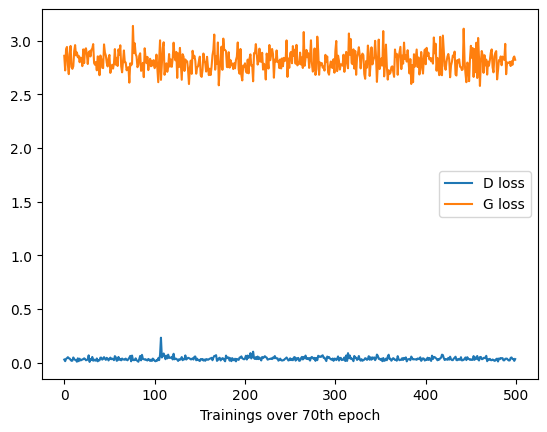

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.45it/s]


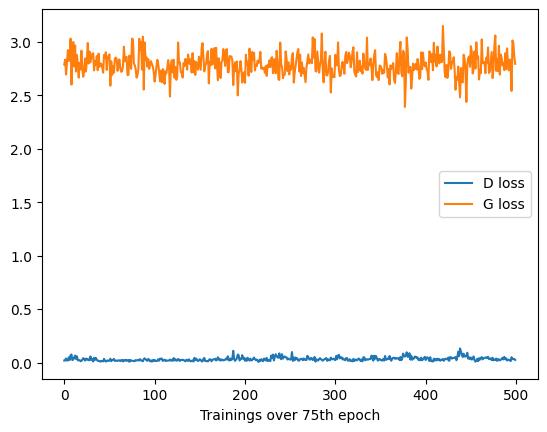

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.41it/s]


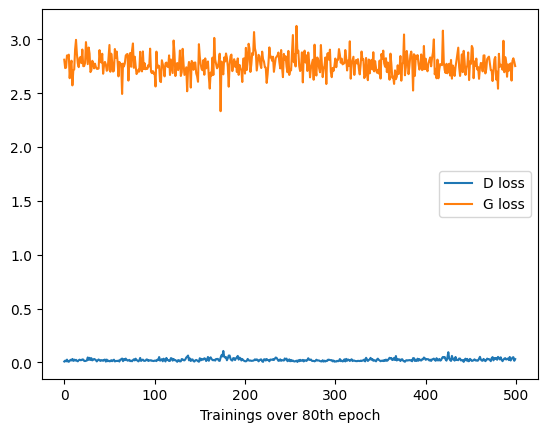

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.45it/s]


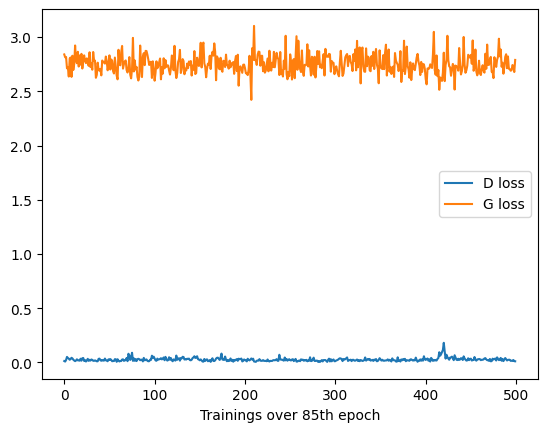

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.38it/s]


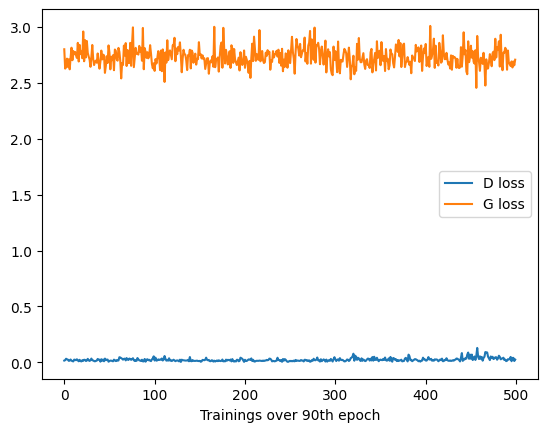

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.38it/s]


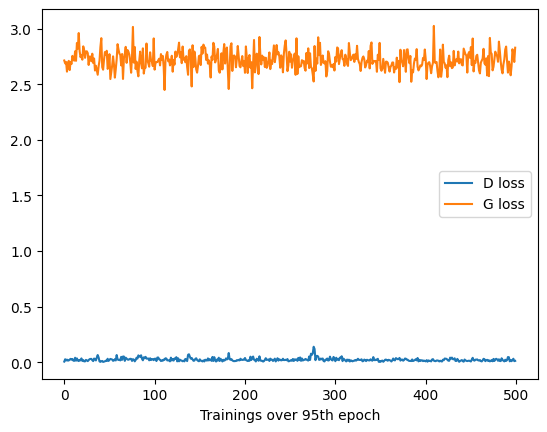

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


100%|██████████| 500/500 [00:40<00:00, 12.36it/s]


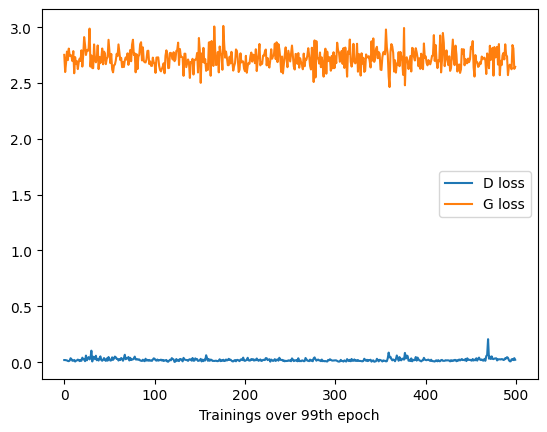

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


In [ ]:
D_all_loss = []
G_all_loss = []

for epoch in range(NUM_EPOCHS):
  d_loss, g_loss = train(disc_A, disc_B, gen_A2B, gen_B2A, loader, opt_disc, opt_gen, L1, mse)

  D_all_loss.extend(d_loss)
  G_all_loss.extend(g_loss)

  # scheduler.step()

  if epoch % 5 == 0 or epoch == NUM_EPOCHS-1:
    plt.plot(d_loss, label='D loss')
    plt.plot(g_loss, label='G loss')
    plt.xlabel('Trainings over {}th epoch'.format(epoch))
    plt.legend()
    plt.show()

    # b = saved_batches[-1]
    # show_batch(b[0], b[1], b[2])

    save_checkpoint(gen_A2B, opt_gen, filename=GENA2B_PATH)
    save_checkpoint(gen_B2A, opt_gen, filename=GENB2A_PATH)
    save_checkpoint(disc_A, opt_disc, filename=DISA_PATH)
    save_checkpoint(disc_B, opt_disc, filename=DISB_PATH)

In [ ]:
for i, batch in enumerate(saved_batches[-5:]):
  show_batch(batch[0], batch[1], batch[2])

Output hidden; open in https://colab.research.google.com to view.